# Analyzing Electrochemical Impedance Spectroscopy data

EIS can be analyzed in several ways:
- Plotting the raw data and inferring behaviors
- Fitting an Equivalent Circuit Model (ECM), which replicates the EIS response of the real system using a predefined electrical circuit, but which does not actually represent the electrochemical charge transfer and mass transfer reactions that are really happening
- Fitting a physics-based model, which is actually solving a predefined system of electrochemical charge transfer and mass transfer reactions, which is more challenging to fit than an ECM but much more insightful (this is not shown in this example)
- Fitting a non-parametric model, i.e., a data-driven model, where the structure and complexity of the model is inferred from the experimental data itself. The most common approach is to fit the distribution of relaxation times (DRT), though here we will use a slightly more complex approach, the coupled Distribution of Relaxation Times - Distribution of Phasances (DRT-DOP) model. A non-parametric model helps to understand the data without making strict assumptions about the nature of the underlying model structure.

The example data used here is from a commercial, large-format Li-ion battery.

### Plotting the raw data
Various EIS analysis python libraries (`impedance`, `HybridDRT`) provide plotting tools to help visualize EIS data properly.

In [1]:
import impedance
import hybdrt

from impedance.preprocessing import readCSV
eis_pristine = readCSV('./data/NMC-Gr Pristine.csv')
eis_aged = readCSV('./data/NMC-Gr Aged.csv')


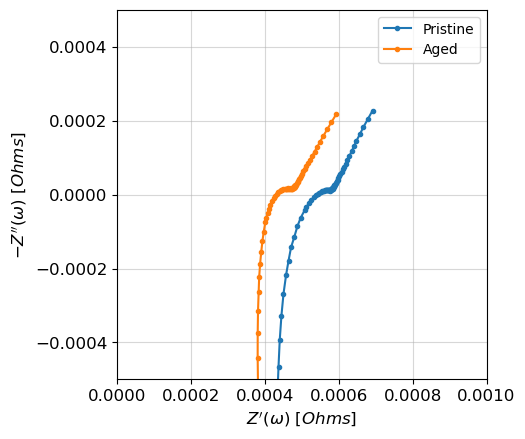

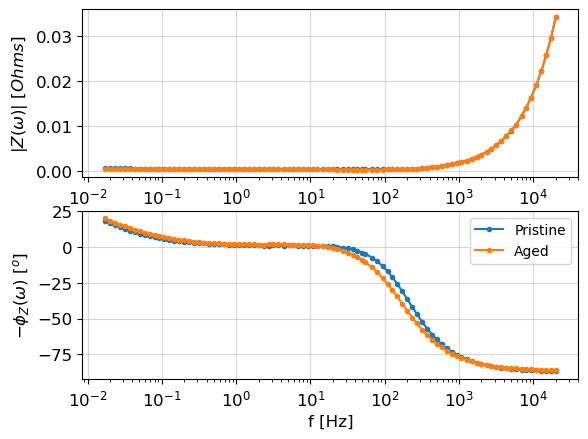

In [2]:
from impedance.visualization import plot_nyquist, plot_bode
import matplotlib.pyplot as plt

plot_fmt = {'labelsize': 12, 'ticksize': 12}

ax = plot_nyquist(eis_pristine[1], label='Pristine', **plot_fmt)
plot_nyquist(eis_aged[1], ax=ax, label='Aged', **plot_fmt)
plt.ylim([-5e-4, 5e-4])
plt.xlim([0, 1e-3])
plt.legend()
ax = plot_bode(eis_pristine[0], eis_pristine[1], label='Pristine', **plot_fmt)
plot_bode(eis_aged[0], eis_aged[1], axes=ax, label='Aged', **plot_fmt)
plt.legend()

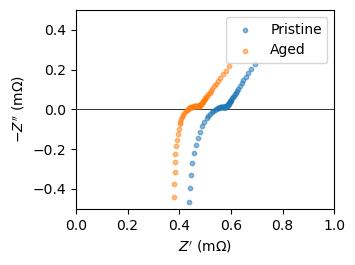

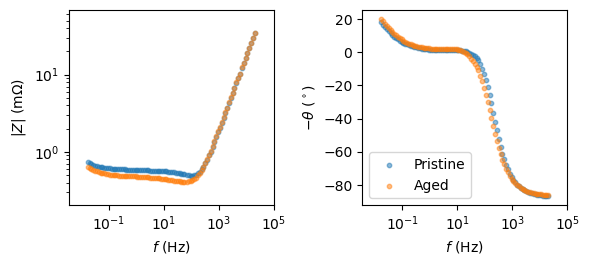

In [3]:
# Slightly different style and functionality from the HybridDRT library but similar outcome.
from hybdrt.plotting import plot_nyquist as plot_nyquist_hybdrt
from hybdrt.plotting import plot_bode as plot_bode_hybdrt

ax = plot_nyquist_hybdrt(eis_pristine, label='Pristine')
plot_nyquist_hybdrt(eis_aged, ax=ax,label='Aged')
plt.ylim([-5e-1, 5e-1])
plt.xlim([0, 1])
plt.legend()
ax = plot_bode_hybdrt(eis_pristine, label='Pristine')
plot_bode_hybdrt(eis_aged, axes=ax, label='Aged')
plt.legend()

### Fitting an Equivalent Circuit Model

The `impedance` library can be used to define and fit an equivalent circuit model.

c:\Users\pgasper\AppData\Local\anaconda3\envs\battery-data-tools\Lib\site-packages\impedance\models\circuits\elements.py:170: RuntimeWarning: overflow encountered in tanh
  Z = Z0 / (np.sqrt(1j * omega * tau) * np.tanh(np.sqrt(1j * omega * tau)))


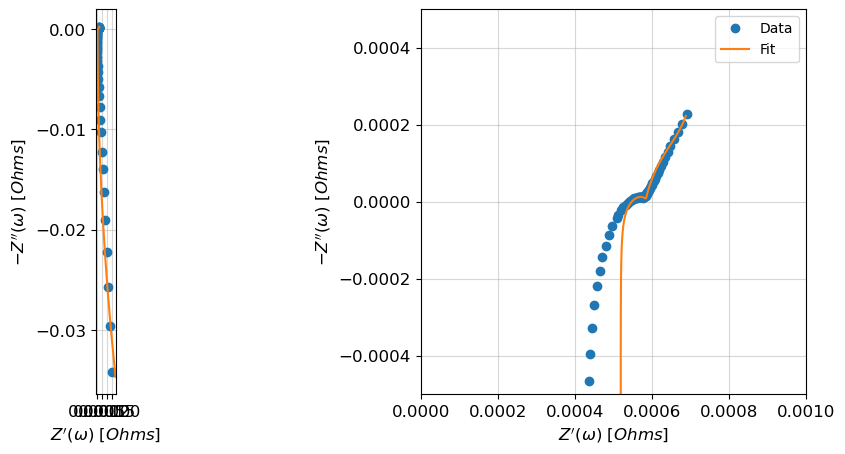

In [7]:
from impedance.models.circuits import CustomCircuit

circuit = 'R0-p(R1,L1)-p(R2,C2)-p(R3-Wo3,C3)'
# A global optimization was done to find a decent initial guess for the parameters
initial_guess = [0.0001, 0.0001, 2e-7, 0.0001, 100, 0.0001, 0.001, 0.01, 1]

circuit = CustomCircuit(circuit, initial_guess=initial_guess)
circuit.fit(eis_pristine[0], eis_pristine[1], global_opt=False)
Z_fit = circuit.predict(eis_pristine[0])

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_nyquist(eis_pristine[1], fmt='o', ax=ax[0], **plot_fmt)
plot_nyquist(Z_fit, fmt='-', ax=ax[0], **plot_fmt)
plot_nyquist(eis_pristine[1], fmt='o', ax=ax[1], **plot_fmt)
plot_nyquist(Z_fit, fmt='-', ax=ax[1], **plot_fmt)
ax[1].set_ylim([-5e-4, 5e-4])
ax[1].set_xlim([0, 1e-3])
ax[1].legend(['Data', 'Fit'])

In [8]:
# Ohmic resistance is simply the first resistor
r_ohmic = circuit.parameters_[0]
# Polarization resistance is the sum of the resistances in the p(R,C) groups
r_polarization = circuit.parameters_[3] + circuit.parameters_[5]

r_ohmic, r_polarization

(np.float64(0.000518635910432695), np.float64(7.629095344211537e-05))

### Fitting the DRT-DOP

The Distribution of Relaxation Times - Distribution of Phasances model is a data-driven model that combines two infinite series of circuit behaviors, estimating their time constants and magnitudes based on the information available in the experimental data. Here's a brief description, for much more detail see (https://doi.org/10.1016/j.joule.2024.05.003)[https://doi.org/10.1016/j.joule.2024.05.003].
1. Distribution of Relaxation Times: An infinite series of parallel resistor and capacitor/inductors. Since the DRT always has resistors in series, the impedance as the frequency approaches zero or infinity will always converge to zero Z_imaginary. So, for instance, this model cannot fit the impedance response of a simple resistor, so the DRT is usually fit in series with a resistor and an inductor.
2. Distribution of Phasances: An infinite series of resistive, inductive, or capacitive responses. The DOP can capture electrical responses that diverge as frequency approaches zero or infinity, such as inductors, resistors, and capacitors, but crucially, these can be non-ideal inductors/capacitors, i.e., frequency dependent capacitance.


Generating impedance integral lookups...
Generating response integral lookups...
Integral lookups ready


c:\Users\pgasper\AppData\Local\anaconda3\envs\battery-data-tools\Lib\site-packages\hybdrt\models\drt1d.py:1024: UserWarning: Solution did not converge within 50 iterations
  warnings.warn(f'Solution did not converge within {max_iter} iterations')


Generating impedance integral lookups...
Generating response integral lookups...
Integral lookups ready


<Axes: xlabel='$-\\theta$ ($^\\circ$)', ylabel='$\\tilde{\\rho}$ (m$\\Omega$)'>

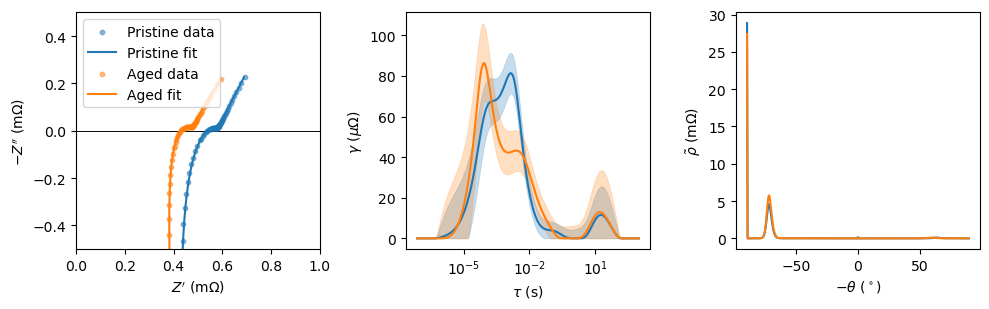

In [16]:
import numpy as np
from hybdrt.models import DRT

# Fit with DRT-DOP
# DRT/DOP is calculated across a range of time constants, tau
tau = (1 / (2 * np.pi * 4e5), 1 / (2 * np.pi * 1e-3))
# Set DOP regularization strength (10:1 DRT:DOP ratio, preferencing explaining the data with a DRT response rather than DOP)
dop_l2_lambda_0 = 20
# Constrain the DRT to be non-negative (not allowing p(R,L) behaviors). This usually results in a more physically meaningful DRT.
nonneg = True
# Instatiate a model object and fit
drt_pristine = DRT(fit_dop=True)
drt_pristine.fit_eis(*eis_pristine, nonneg=nonneg, dop_l2_lambda_0=dop_l2_lambda_0)
drt_aged = DRT(fit_dop=True)
drt_aged.fit_eis(*eis_aged, nonneg=nonneg, dop_l2_lambda_0=dop_l2_lambda_0)


# Plotting
fig, axes = plt.subplots(1, 3, figsize=(10, 10 * 0.32))
# EIS
plot_nyquist_hybdrt(eis_pristine, ax=axes[0], c='tab:blue', label='Pristine data')
plot_nyquist_hybdrt((eis_pristine[0], drt_pristine.predict_z(eis_pristine[0])), plot_func='plot', c='tab:blue', ax=axes[0], label='Pristine fit')
plot_nyquist_hybdrt(eis_aged, ax=axes[0], c='tab:orange', label='Aged data')
plot_nyquist_hybdrt((eis_aged[0], drt_aged.predict_z(eis_aged[0])), plot_func='plot', c='tab:orange', ax=axes[0], label='Aged fit')
axes[0].legend()
axes[0].set_ylim([-5e-1, 5e-1])
axes[0].set_xlim([0, 1])
# DRT
drt_pristine.plot_distribution(ax=axes[1], c='tab:blue', plot_ci=True)
drt_aged.plot_distribution(ax=axes[1], c='tab:orange', plot_ci=True)
# DOP
drt_pristine.plot_dop(ax=axes[2], c='tab:blue', normalize=True)
drt_aged.plot_dop(ax=axes[2], c='tab:orange', normalize=True)


The DRT (middle graph) shows that the majority of the resistive-capacitive behavior occurs in the middle frequency regimes. It looks like most of the change in behavior between the two curves is due to a decrease of resistive-capacitive impedance at middle frequencies (tau = 1e-2), offset by a slight increase of resistive-capacitive impedance at higher frequencies (tau = 1e-4).